## Context

In autonomous driving, the Frenet coordinate system is often used. In the Frenet system, the coordinate of an object is defined by two values: the longitudinal and the lateral position of the object with respect to a reference line.

In this problem, the reference is given as a finite list of points. 

### Constructs a continuous reference line given an input list of points in a cartersian coordinate C1

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import math
import bisect

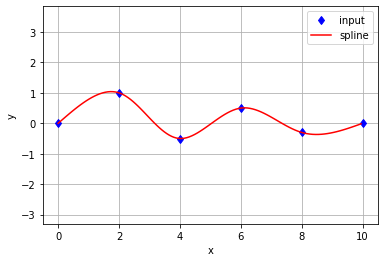

In [2]:
class Spline:
    """
    Cubic Spline class
    """

    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of x
        h = np.diff(x)

        # calc coefficient c
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        """
        Calc position
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """
    2D Cubic Spline class
    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

def generate_target_course(x, y):
    csp = Spline2D(x, y)
    s = np.arange(0, csp.s[-1], 0.1)

    rx, ry = [], []
    for i_s in s:
        ix, iy = csp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)

    return rx, ry, csp

'''
x = [0.0, 1.99999809265, 3.9999961853, 5.99999237061, 7.99998664856, 9.99997901917, 11.9999675751, 
    13.9999542236, 15.9999389648, 17.9999198914, 19.9998970032, 21.9998703003, 23.9998397827,
    25.9998054504, 27.9997653961, 29.9997215271, 31.999671936, 33.9996185303, 35.9995574951, 37.9994926453,
    39.999420166, 41.9993400574]
y = [0.119615256786, 0.116609536111, 0.112853787839, 0.10834787786, 0.103091679513, 0.0970850288868, 
    0.0903278365731, 0.0828199386597, 0.074561201036, 0.0655515044928, 0.055790707469, 0.0452786684036,
    0.0340152792633, 0.0220003835857, 0.00923385843635, -0.00428441539407, -0.0185545757413, -0.0335767753422,
    -0.049351092428, -0.065877713263, -0.0831567272544, -0.101188264787]
'''

x = [0, 2, 4, 6, 8, 10]
y = [0, 1, -0.5, 0.5, -0.3, 0]
ds = 0.1  # distance of each intepolated points


sp = Spline2D(x, y)
s = np.arange(0, sp.s[-1], ds)

[rx, ry, csp] = generate_target_course(x, y)
plt.plot(x, y, "db", label="input")
plt.plot(rx, ry, "-r", label="spline")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

### Provides functionality to convert any point in the cartersian coordinate C1 (that is, in the same coordinate with the list of points used to construct the continuous reference line) to the frenet coordinate. Following the direction of the given input points, the first point on the input list has the longitudinal position of 0. All points on the reference line have the lateral position of 0. All points to the left of the reference line have negative lateral position and all points to the right have the positive lateral position.

In [3]:
# set reference waypoint we 
w_x =rx
w_y =ry

In [4]:
# Distance between 2 points
def distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) * (x2 - x1) + (y2 - y1) * (y2 - y1))

# Finding the closest way point to a given point
def ClosestWaypoint(x, y, w_x, w_y):
    closest_distance = float('Inf') # initiate big number
    closest_wp_idx = 0
    
    for i in range (len(w_x)):
        dist = distance(x, y, w_x[i], w_y[i])
        
        if(dist < closest_distance):
            closest_distance = dist
            closest_wp_idx = i
            
    return closest_wp_idx

# Cartesian coordinate to Frenet coordinate
def cart2fre(x, y, w_x, w_y):
    # get next way point
    next_wp = ClosestWaypoint(x, y, w_x, w_y)
    prev_wp = next_wp - 1
    
    if(next_wp == 0):
        prev_wp = len(w_x)-1
        
    n_x = w_x[next_wp] - w_x[prev_wp]
    n_y = w_y[next_wp] - w_y[prev_wp]
    
    d_x = x - w_x[prev_wp]
    d_y = y - w_y[prev_wp]
    
    # projection of x onto n
    proj_norm = (d_x * n_x + d_y * n_y) / (n_x * n_x + n_y * n_y)
    proj_x = proj_norm * n_x
    proj_y = proj_norm * n_y
    
    frenet_d = distance(d_x, d_y, proj_x, proj_y)
    
    # right side is positive, left side is negative
    center_x = 1000 - w_x[prev_wp]
    center_y = 1000 - w_y[prev_wp]
    centerToPos = distance(center_x, center_y, d_x, d_y)
    centerToRef = distance(center_x, center_y, proj_x, proj_y)

    if(centerToPos <= centerToRef):
        frenet_d *= -1

    # calculate s value
    frenet_s = 0
    for i in range (prev_wp):
        frenet_s += distance(w_x[i], w_y[i], w_x[i+1], w_y[i+1])
    frenet_s += distance(0, 0, proj_x, proj_y)
    # the first point on the input list has the longitudinal position of 0
    if(next_wp == 0):
        frenet_s = 0.0    

    return(frenet_d,frenet_s)

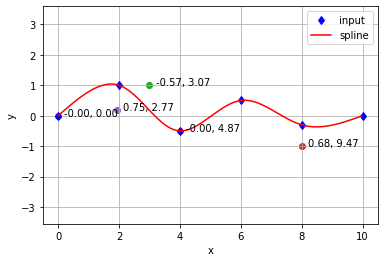

In [7]:
def plt_annotate (x, y):
    plt.scatter(x, y)
    plt.annotate("{:.2f}".format(cart2fre(x, y, w_x, w_y)[0]) 
                 + ", {:.2f}".format(cart2fre(x, y, w_x, w_y)[1]), ((x+0.2),y));
plt.plot(x, y, "db", label="input")
plt.plot(rx, ry, "-r", label="spline")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

import random
x_test = random.uniform(0, 10)
y_test = random.uniform(-1, 1)
# point on reference line
plt_annotate (0, 0)
plt_annotate (4, -0.5)

# point on left side of reference
plt_annotate (3, 1)
# point on right side of reference
plt_annotate (8, -1)

# random point
plt_annotate (x_test, y_test)